# Layer Analytics of Neural Networks


In [1]:
import os, sys, math, datetime
import psutil

# import pathlib
from pathlib import Path
import numpy as np
import pandas as pd
import random
from matplotlib import pyplot as plt
import PIL
import PIL.Image

# Import the necessary MLTK APIs
from mltk.core import view_model, summarize_model, profile_model
# from mltk.utils.commander import query_platform

import tensorflow as tf
# import tensorflow_datasets as tfds
#from tensorflow import keras
keras = tf.keras
from keras.layers import (
    Input,
    Dense,
    Flatten,
    Conv2D,
    MaxPooling2D,
    GlobalAveragePooling2D,
    BatchNormalization,
    Concatenate,
)
# from tensorflow.keras.models import Model
# from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# import workbench.config.config
from workbench.config.config import initialize
from workbench.utils.utils import create_filepaths

In [2]:
models_dir = initialize()

In [3]:
#model_name = "mobilenetv2_0.1_96_c3_o3_keras"
model_name = "shufflenetv2tiny_0.1_96_c3_o3_f4l1024"
#model_name = "efficientNetB0_0.1_96_c3_o3_keras"
#model_name = "MobilenetV3small_0.1_96_c3_o3_keras"

In [4]:
models_tf_path = f"i:/tinyml/tiny_cnn/models/{model_name}/{model_name}.h5"

In [5]:
# def get_flops_params():
#     sess_aha = tf.compat.v1.Session()
#     graph = sess_aha.graph
#     flops = tf.compat.v1.profiler.profile(graph, options=tf.compat.v1.profiler.ProfileOptionBuilder.float_operation())
#     params = tf.compat.v1.profiler.profile(graph, options=tf.compat.v1.profiler.ProfileOptionBuilder.trainable_variables_parameter())
#     print('FLOPs: {};    Trainable params: {}'.format(flops.total_float_ops, params.total_parameters))

# from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
# from tensorflow.keras.models import Sequential

# model = keras.models.load_model(models_tf_path)
# # newmodel = Sequential()
# # newmodel.add(Conv2D(filters=64, kernel_size=(3, 3), input_shape=(28, 28, 1), activation='relu'))
# # newmodel.add(MaxPooling2D(pool_size=(2, 2)))
# # newmodel.add(Flatten())
# # newmodel.add(Dense(units=100, activation='relu'))
# # newmodel.add(Dense(units=10, activation='softmax'))

# # newmodel.summary()
# #model.summary()
# get_flops_params()

# # clear out garbage
# tf.keras.backend.clear_session()

In [6]:
# Configure pandas to show all columns & rows
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)

# Helper Functions

In [7]:
# Helper functions


def flat_size(shape: list):
    out = 1
    for k in shape:
        out *= k

    return out

# Get the model

In [8]:
model = keras.models.load_model(models_tf_path)

In [9]:
#model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

In [10]:
summary = model.summary(expand_nested=True)

Model: "shufflenetv2tiny"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 96, 96, 3)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 47, 47, 4)    108         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 47, 47, 4)   16          ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                                  
 re_lu (ReLU)                   (None, 47, 47, 4)    0           ['batch_normalizat

In [11]:
mltk_summary = summarize_model(model)
print(mltk_summary)

Model: "shufflenetv2tiny"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 96, 96, 3)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 47, 47, 4)    108         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 47, 47, 4)   16          ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                                  
 re_lu (ReLU)                   (None, 47, 47, 4)    0           ['batch_normalizat

In [12]:
# MLTK profile model reads the mode from a path - only works for MLTK models!

#profiling_results = profile_model(models_tf_path, accelerator='MVP', build=True)

In [13]:
# Show model in local version of Netron.app
#view_model(model, tflite=True, build=True)

In [14]:
(
    models_path,
    models_summary_path,
    models_image_path,
    models_layer_df_path,
    models_tf_path,
    models_tflite_path,
    models_tflite_opt_path,
) = create_filepaths(model_name)

i:\tinyml\tiny_cnn\models


In [15]:
models_layer_df_path

WindowsPath('i:/tinyml/tiny_cnn/models/shufflenetv2tiny_0.1_96_c3_o3_f4l1024/shufflenetv2tiny_0.1_96_c3_o3_f4l1024_layers.pkl')

# Get details from the different layers of the model

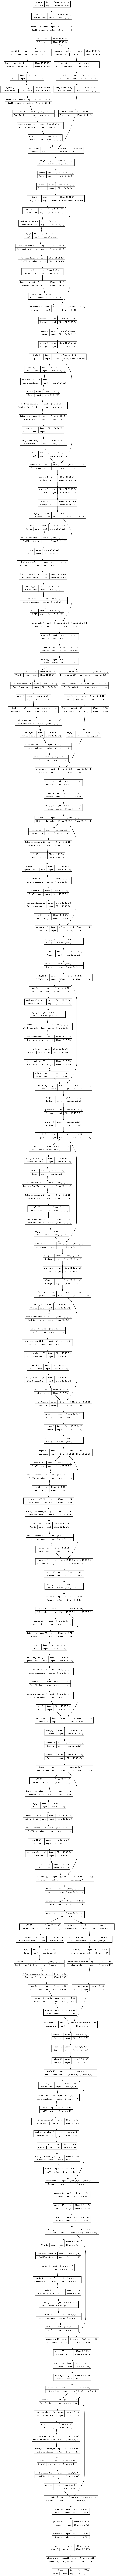

In [16]:
tf.keras.utils.plot_model(
    model,
    to_file=models_image_path,
    show_shapes=True,
    show_dtype=False,
    show_layer_names=True,
    rankdir="TB",  # TB for vertical plot, LR for horizontal plot
    expand_nested=True,
    layer_range=None,
    dpi=200,
    show_layer_activations=True,
)

# Layer Metrics Helper Functions

In [17]:
def Conv2D_MACs(layer):
    """
    Code adapted from https://github.com/SiliconLabs/mltk/blob/master/mltk/core/model/metrics/layers/conv.py
    """

    if isinstance(layer, keras.layers.Conv2D):
        _, _, _, in_depth = layer.input_shape  # layer.input_data.shape
        _, out_h, out_w, out_depth = layer.output_shape  # layer.output_data.shape
    else:
        if layer.data_format == "channels_first":
            _, in_depth, _, _ = layer.input_shape
            (
                _,
                out_depth,
                out_h,
                out_w,
            ) = layer.output_shape
        elif layer.data_format == "channels_last":
            _, _, _, in_depth = layer.input_shape
            _, out_h, out_w, out_depth = layer.output_shape

    w_h, w_w = layer.kernel_size
    name = layer.name
    macs = w_h * w_w * in_depth * out_w * out_h * out_depth
    ops = macs * 2

    if layer.use_bias:
        ops += out_w * out_h * out_depth

    return (name, macs, ops)

In [18]:
def DepthwiseConv2D_MACs(layer):
    """
    Code adapted from https://github.com/SiliconLabs/mltk/blob/master/mltk/core/model/metrics/layers/depthwise_conv.py
    """

    # if isinstance(layer, TfliteDepthwiseConv2dLayer):
    #     _, _, _, in_depth = layer.input_data.shape
    #     _, out_h, out_w, out_depth = layer.output_data.shape

    # else: keras.layers.DepthwiseConv2D
    if isinstance(layer, keras.layers.DepthwiseConv2D):
        if layer.data_format == "channels_first":
            _, in_depth, _, _ = layer.input_shape
            (
                _,
                out_depth,
                out_h,
                out_w,
            ) = layer.output_shape
        elif layer.data_format == "channels_last":
            _, _, _, in_depth = layer.input_shape
            _, out_h, out_w, out_depth = layer.output_shape

    w_h, w_w = layer.kernel_size
    depth_multiplier = out_depth // in_depth

    name = layer.name
    macs = w_h * w_w * depth_multiplier * in_depth * out_w * out_h
    ops = macs * 2

    if layer.use_bias:
        ops += depth_multiplier * in_depth * out_w * out_h

    return (name, macs, ops)

In [19]:
def SeparableConv2D_MACs(layer):
    """
    Code adapted from https://github.com/SiliconLabs/mltk/blob/master/mltk/core/model/metrics/layers/depthwise_conv.py
    """
    name = layer.name
    if isinstance(layer, keras.layers.SeparableConv2D):
        if layer.data_format == "channels_first":
            _, in_depth, _, _ = layer.input_shape
            (
                _,
                out_depth,
                out_h,
                out_w,
            ) = layer.output_shape
        elif layer.data_format == "channels_last":
            _, _, _, in_depth = layer.input_shape
            _, out_h, out_w, out_depth = layer.output_shape

    else:
        return (name, "mac_error", "ops_error")

    w_h, w_w = layer.kernel_size

    macs_depth = w_h * w_w * in_depth * out_w * out_h
    macs_point = in_depth * out_w * out_h * out_depth
    macs = macs_depth + macs_point
    ops = macs * 2

    if layer.use_bias:
        ops += in_depth * out_w * out_h  # for depthwise convolution
        ops += (
            out_w * out_h * out_depth
        )  # for pointwise convolution ## TODO: check the calculations

    return (name, macs, ops)

In [20]:
def Dense_MACs(layer):
    """
    Code adapted from https://github.com/SiliconLabs/mltk/blob/master/mltk/core/model/metrics/layers/dense.py
    """

    if isinstance(layer, keras.layers.Dense):
        bias_ops = 0
        # if isinstance(layer, TfliteFullyConnectedLayer):
        #     in_depth = layer.input_data.shape[-1]
        #     out_depth = layer.output_data.shape[-1]
        #     if layer.use_bias:
        #         bias_ops = layer.outputs[0].shape.flat_size
        # else:
        in_depth = layer.input_shape[-1]
        out_depth = layer.output_shape[-1]
        if layer.use_bias:
            bias_ops = flat_size(layer.output_shape[1:])

        name = layer.name
        macs = in_depth * out_depth
        ops = macs * 2 + bias_ops

    return (name, macs, ops)

In [21]:
def AveragePooling2D_MACs(layer):
    """
    Code adapted from https://github.com/SiliconLabs/mltk/blob/master/mltk/core/model/metrics/layers/pooling.py
    """

    if isinstance(layer, keras.layers.AveragePooling2D):
        f_h, f_w = layer.pool_size
        name = layer.name
        # if isinstance(layer, KerasLayer):
        output_shape = layer.output_shape
        # else:
        #     output_shape = layer.outputs[0].shape

        ops = flat_size(output_shape[1:]) * (f_h * f_w + 1)  # + 1 for the division

    return (name, ops)

In [22]:
# def calculate_no_activations(layer):
#     if isinstance(
#         layer, (keras.layers.Conv2D, keras.layers.Dense, keras.layers.DepthwiseConv2D)
#     ):  # , )):keras.layers.Input
#         # if isinstance(layer, (keras.layers.Conv2D)):
#         # if isinstance(layer, (keras.layers.DepthwiseConv2D)):
#         # if isinstance(layer, (keras.layers)):
#         if layer.data_format == "channels_first":
#             (
#                 _,
#                 out_depth,
#                 out_h,
#                 out_w,
#             ) = layer.output_shape
#         elif layer.data_format == "channels_last":
#             _, out_h, out_w, out_depth = layer.output_shape

#         return out_h * out_w * out_depth

#     else:
#         return 0

In [23]:
def print_layer_config(layer, layer_type):
    if isinstance(layer, layer_type):
        print(f"  Layer: {type(layer)}")
        print(layer.get_config())
        print()
    else:
        pass
    return layer.layer_config

In [24]:
def parse_layer_input(layer_input):
    """Parses the tf.model.layers.input and extracts the following node infos:
        - node_name(s) of all input nodes
        - node_type(s) of all input nodes

    Args:
        layer_input (tf.model.layers.input): _description_

    Returns:
        dict: Dictionary containing the extracted node input infos
    """
    input_dict = {}
    if type(layer_input) is list:
        for i, item in enumerate(layer_input, start=1):
            #print(f"Input_{i}: {item.__dict__['_name']}")
            node_name, node_type = item.__dict__['_name'].split("/")
            input_dict[f"input_node_{i}"] = node_name
            input_dict[f"input_node_type_{i}"] = node_type
            #input_dict[f"input_{i}_shape"] = item.shape

    # elif tf.is_tensor(layer_input):
    #     print("Tensor!") # TODO: This part is not yet producing the correct outputs
    #     #input_dict["input_node_1"] = layer_input.name
    #     input_dict["input_1_shape"] = layer_input#[0].shape        
    else:
        try:
            print(f"Layer: {i}: {type(layer_input)}")
            node_name, node_type = layer_input.__dict__['_name'].split("/")
            input_dict["input_node_1"] = node_name
            input_dict["input_node_type_1"] = node_type
            #input_dict["input_1_shape"] = layer_input[0].shape
        except:
            print(f"Layer: : #EXCEPTION {type(layer_input)}")
            input_dict["input_node_1"] = layer_input.__dict__['_name']
    #print(input_dict)
    return input_dict



#     i = 9
# l_inputs = model.layers[i].input
# l_inputs

# Extract layer infos

In [30]:
def get_layer_list(model):
    layer_list = []
    for i, layer in enumerate(model.layers):
        layer_stats = {}
        layer_stats["index"] = i
        layer_stats["name"] = layer.name
        layer_stats["layer_type"] = type(layer)  # TODO: find a better representation
        layer_stats["input_shape"] = layer.input_shape

        layer_stats["input"] = layer.input

        layer_input_dict = parse_layer_input(layer.input)
        layer_stats |= layer_input_dict # new Python 3.9 dict merge operation 
        #layer_stats.update(layer_input_dict)

        layer_stats["output_shape"] = layer.output_shape
        layer_stats["dtype"] = layer.compute_dtype
        layer_stats["params"] = layer.count_params()
        layer_stats["variables"] = len(layer.variables)
        try:
            layer_stats["weights_shape"] = layer.weights[0].shape
            layer_stats["weights_name"] = layer.weights[0].name
            layer_stats["weights_dtype"] = layer.weights[0].dtype
            #layer_stats["#_activations"] = calculate_no_activations(layer)

        except:
            layer_stats["weights_shape"] = 0
            layer_stats["weights_name"] = 0
            layer_stats["weights_dtype"] = 0
            layer_stats["#_activations"] = 0


        layer_config = layer.get_config()

        # Set default values for parameters that are not present in each layer
        layer_stats["OPS"] = 0
        layer_stats["MACS"] = 0
        layer_stats["filters"] = 0
        layer_stats["trainable"] = 0
        layer_stats["kernel_size"] = 0
        layer_stats["strides"] = 0
        layer_stats["padding"] = 0
        layer_stats["dilation_rate"] = 0
        layer_stats["groups"] = 0
        layer_stats["activation"] = 0
        layer_stats["use_bias"] = 0
        layer_stats["data_format"] = 0

        # if isinstance(layer, keras.layers.InputLayer):
        #     print(f"  Layer: {type(layer)}")
        #     print(layer_config)
        #     print()

        if isinstance(layer, keras.layers.Conv2D):
            # print(f"  Layer: {type(layer)}")
            # print(layer_config)
            # print()
            name, macs, ops = Conv2D_MACs(layer)

            layer_stats["OPS"] = ops
            layer_stats["MACS"] = macs
            # layer_stats["# activation"] = layer.output_shape[1]
            layer_stats["filters"] = layer_config["filters"]
            layer_stats["trainable"] = layer_config["trainable"]
            layer_stats["kernel_size"] = layer_config["kernel_size"]
            layer_stats["strides"] = layer_config["strides"]
            layer_stats["padding"] = layer_config["padding"]
            layer_stats["dilation_rate"] = layer_config["dilation_rate"]
            layer_stats["groups"] = layer_config["groups"]
            layer_stats["activation"] = layer_config["activation"]
            layer_stats["use_bias"] = layer_config["use_bias"]
            layer_stats["data_format"] = layer_config["data_format"]

        if isinstance(layer, keras.layers.DepthwiseConv2D):
            # print(f"  Layer: {type(layer)}")
            # print(layer_config)
            # print()

            name, macs, ops = DepthwiseConv2D_MACs(layer)

            # layer_stats["filters"]= layer_config["filters"]  # TODO: key error -> refactor with Conv2D
            layer_stats["OPS"] = ops
            layer_stats["MACS"] = macs
            layer_stats["trainable"] = layer_config["trainable"]
            layer_stats["kernel_size"] = layer_config["kernel_size"]
            layer_stats["strides"] = layer_config["strides"]
            layer_stats["padding"] = layer_config["padding"]
            layer_stats["dilation_rate"] = layer_config["dilation_rate"]
            layer_stats["groups"] = layer_config["groups"]
            layer_stats["activation"] = layer_config["activation"]
            layer_stats["use_bias"] = layer_config["use_bias"]
            layer_stats["data_format"] = layer_config["data_format"]

        # if isinstance(layer, keras.layers.Dense):
        #     print(f"  Layer: {type(layer)}")
        #     print(layer_config)
        #     print()

        # if isinstance(layer, keras.layers.BatchNormalization ):
        #     print(f"  Layer: {type(layer)}")
        #     print(layer_config)
        #     print()
        layer_list.append(layer_stats)
    return layer_list

In [32]:
layer_list = get_layer_list(model)


Layer: : #EXCEPTION <class 'keras.engine.keras_tensor.KerasTensor'>
Layer: : #EXCEPTION <class 'keras.engine.keras_tensor.KerasTensor'>
Layer: : #EXCEPTION <class 'keras.engine.keras_tensor.KerasTensor'>
Layer: : #EXCEPTION <class 'keras.engine.keras_tensor.KerasTensor'>
Layer: : #EXCEPTION <class 'keras.engine.keras_tensor.KerasTensor'>
Layer: : #EXCEPTION <class 'keras.engine.keras_tensor.KerasTensor'>
Layer: : #EXCEPTION <class 'keras.engine.keras_tensor.KerasTensor'>
Layer: : #EXCEPTION <class 'keras.engine.keras_tensor.KerasTensor'>
Layer: : #EXCEPTION <class 'keras.engine.keras_tensor.KerasTensor'>
Layer: : #EXCEPTION <class 'keras.engine.keras_tensor.KerasTensor'>
Layer: : #EXCEPTION <class 'keras.engine.keras_tensor.KerasTensor'>
Layer: : #EXCEPTION <class 'keras.engine.keras_tensor.KerasTensor'>
Layer: : #EXCEPTION <class 'keras.engine.keras_tensor.KerasTensor'>
Layer: : #EXCEPTION <class 'keras.engine.keras_tensor.KerasTensor'>
Layer: : #EXCEPTION <class 'keras.engine.keras_t

In [36]:
layer_stats_df = pd.DataFrame.from_dict(layer_list)
layer_stats_df.head(20)

,index,name,layer_type,input_shape,input,input_node_1,output_shape,dtype,params,variables,weights_shape,weights_name,weights_dtype,#_activations,OPS,MACS,filters,trainable,kernel_size,strides,padding,dilation_rate,groups,activation,use_bias,data_format,input_node_type_1,input_node_2,input_node_type_2
0,0,input_1,<class 'keras.engine.input_layer.InputLayer'>,"[(None, 96, 96, 3)]","KerasTensor(type_spec=TensorSpec(shape=(None, ...",input_1,"[(None, 96, 96, 3)]",float32,0,0,0,0,0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN
1,1,conv2d,<class 'keras.layers.convolutional.conv2d.Conv...,"(None, 96, 96, 3)","KerasTensor(type_spec=TensorSpec(shape=(None, ...",input_1,"(None, 47, 47, 4)",float32,108,1,"(3, 3, 3, 4)",conv2d/kernel:0,<dtype: 'float32'>,NaN,477144,238572,4,True,"(3, 3)","(2, 2)",valid,"(1, 1)",1,linear,False,channels_last,NaN,NaN,NaN
2,2,batch_normalization,<class 'keras.layers.normalization.batch_norma...,"(None, 47, 47, 4)","KerasTensor(type_spec=TensorSpec(shape=(None, ...",conv2d/Conv2D:0,"(None, 47, 47, 4)",float32,16,4,(4),batch_normalization/gamma:0,<dtype: 'float32'>,NaN,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN
3,3,re_lu,<class 'keras.layers.activation.relu.ReLU'>,"(None, 47, 47, 4)","KerasTensor(type_spec=TensorSpec(shape=(None, ...",batch_normalization/FusedBatchNormV3:0,"(None, 47, 47, 4)",float32,0,0,0,0,0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN
4,4,conv2d_1,<class 'keras.layers.convolutional.conv2d.Conv...,"(None, 47, 47, 4)","KerasTensor(type_spec=TensorSpec(shape=(None, ...",re_lu/Relu:0,"(None, 47, 47, 12)",float32,48,1,"(1, 1, 4, 12)",conv2d_1/kernel:0,<dtype: 'float32'>,NaN,212064,106032,12,True,"(1, 1)","(1, 1)",same,"(1, 1)",1,linear,False,channels_last,NaN,NaN,NaN
5,5,batch_normalization_1,<class 'keras.layers.normalization.batch_norma...,"(None, 47, 47, 12)","KerasTensor(type_spec=TensorSpec(shape=(None, ...",conv2d_1/Conv2D:0,"(None, 47, 47, 12)",float32,48,4,(12),batch_normalization_1/gamma:0,<dtype: 'float32'>,NaN,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN
6,6,re_lu_1,<class 'keras.layers.activation.relu.ReLU'>,"(None, 47, 47, 12)","KerasTensor(type_spec=TensorSpec(shape=(None, ...",batch_normalization_1/FusedBatchNormV3:0,"(None, 47, 47, 12)",float32,0,0,0,0,0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN
7,7,depthwise_conv2d,<class 'keras.layers.convolutional.depthwise_c...,"(None, 47, 47, 12)","KerasTensor(type_spec=TensorSpec(shape=(None, ...",re_lu_1/Relu:0,"(None, 24, 24, 12)",float32,108,1,"(3, 3, 12, 1)",depthwise_conv2d/depthwise_kernel:0,<dtype: 'float32'>,NaN,124416,62208,0,True,"(3, 3)","(2, 2)",same,"(1, 1)",1,linear,False,channels_last,NaN,NaN,NaN
8,8,depthwise_conv2d_1,<class 'keras.layers.convolutional.depthwise_c...,"(None, 47, 47, 4)","KerasTensor(type_spec=TensorSpec(shape=(None, ...",re_lu/Relu:0,"(None, 24, 24, 4)",float32,36,1,"(3, 3, 4, 1)",depthwise_conv2d_1/depthwise_kernel:0,<dtype: 'float32'>,NaN,41472,20736,0,True,"(3, 3)","(2, 2)",same,"(1, 1)",1,linear,False,channels_last,NaN,NaN,NaN
9,9,batch_normalization_2,<class 'keras.layers.normalization.batch_norma...,"(None, 24, 24, 12)","KerasTensor(type_spec=TensorSpec(shape=(None, ...",depthwise_conv2d/depthwise:0,"(None, 24, 24, 12)",float32,48,4,(12),batch_normalization_2/gamma:0,<dtype: 'float32'>,NaN,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN


,index,name,layer_type,input_shape,input,input_node_1,output_shape,dtype,params,variables,weights_shape,weights_name,weights_dtype,#_activations,OPS,MACS,filters,trainable,kernel_size,strides,padding,dilation_rate,groups,activation,use_bias,data_format,input_node_type_1,input_node_2,input_node_type_2
0,0,input_1,<class 'keras.engine.input_layer.InputLayer'>,"[(None, 96, 96, 3)]","KerasTensor(type_spec=TensorSpec(shape=(None, ...",input_1,"[(None, 96, 96, 3)]",float32,0,0,0,0,0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN
1,1,conv2d,<class 'keras.layers.convolutional.conv2d.Conv...,"(None, 96, 96, 3)","KerasTensor(type_spec=TensorSpec(shape=(None, ...",input_1,"(None, 47, 47, 4)",float32,108,1,"(3, 3, 3, 4)",conv2d/kernel:0,<dtype: 'float32'>,NaN,477144,238572,4,True,"(3, 3)","(2, 2)",valid,"(1, 1)",1,linear,False,channels_last,NaN,NaN,NaN
2,2,batch_normalization,<class 'keras.layers.normalization.batch_norma...,"(None, 47, 47, 4)","KerasTensor(type_spec=TensorSpec(shape=(None, ...",conv2d/Conv2D:0,"(None, 47, 47, 4)",float32,16,4,(4),batch_normalization/gamma:0,<dtype: 'float32'>,NaN,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN
3,3,re_lu,<class 'keras.layers.activation.relu.ReLU'>,"(None, 47, 47, 4)","KerasTensor(type_spec=TensorSpec(shape=(None, ...",batch_normalization/FusedBatchNormV3:0,"(None, 47, 47, 4)",float32,0,0,0,0,0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN
4,4,conv2d_1,<class 'keras.layers.convolutional.conv2d.Conv...,"(None, 47, 47, 4)","KerasTensor(type_spec=TensorSpec(shape=(None, ...",re_lu/Relu:0,"(None, 47, 47, 12)",float32,48,1,"(1, 1, 4, 12)",conv2d_1/kernel:0,<dtype: 'float32'>,NaN,212064,106032,12,True,"(1, 1)","(1, 1)",same,"(1, 1)",1,linear,False,channels_last,NaN,NaN,NaN
5,5,batch_normalization_1,<class 'keras.layers.normalization.batch_norma...,"(None, 47, 47, 12)","KerasTensor(type_spec=TensorSpec(shape=(None, ...",conv2d_1/Conv2D:0,"(None, 47, 47, 12)",float32,48,4,(12),batch_normalization_1/gamma:0,<dtype: 'float32'>,NaN,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN
6,6,re_lu_1,<class 'keras.layers.activation.relu.ReLU'>,"(None, 47, 47, 12)","KerasTensor(type_spec=TensorSpec(shape=(None, ...",batch_normalization_1/FusedBatchNormV3:0,"(None, 47, 47, 12)",float32,0,0,0,0,0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN
7,7,depthwise_conv2d,<class 'keras.layers.convolutional.depthwise_c...,"(None, 47, 47, 12)","KerasTensor(type_spec=TensorSpec(shape=(None, ...",re_lu_1/Relu:0,"(None, 24, 24, 12)",float32,108,1,"(3, 3, 12, 1)",depthwise_conv2d/depthwise_kernel:0,<dtype: 'float32'>,NaN,124416,62208,0,True,"(3, 3)","(2, 2)",same,"(1, 1)",1,linear,False,channels_last,NaN,NaN,NaN
8,8,depthwise_conv2d_1,<class 'keras.layers.convolutional.depthwise_c...,"(None, 47, 47, 4)","KerasTensor(type_spec=TensorSpec(shape=(None, ...",re_lu/Relu:0,"(None, 24, 24, 4)",float32,36,1,"(3, 3, 4, 1)",depthwise_conv2d_1/depthwise_kernel:0,<dtype: 'float32'>,NaN,41472,20736,0,True,"(3, 3)","(2, 2)",same,"(1, 1)",1,linear,False,channels_last,NaN,NaN,NaN
9,9,batch_normalization_2,<class 'keras.layers.normalization.batch_norma...,"(None, 24, 24, 12)","KerasTensor(type_spec=TensorSpec(shape=(None, ...",depthwise_conv2d/depthwise:0,"(None, 24, 24, 12)",float32,48,4,(12),batch_normalization_2/gamma:0,<dtype: 'float32'>,NaN,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN


# Check for errors

In [27]:
layer_stats_df[layer_stats_df["OPS"]=="ops_error"]

,index,name,layer_type,input_shape,input,input_node_1,output_shape,dtype,params,variables,weights_shape,weights_name,weights_dtype,#_activations,OPS,MACS,filters,trainable,kernel_size,strides,padding,dilation_rate,groups,activation,use_bias,data_format,input_node_type_1,input_node_2,input_node_type_2


In [28]:
layer_stats_df["layer_type"].unique()

array([<class 'keras.engine.input_layer.InputLayer'>,
       <class 'keras.layers.convolutional.conv2d.Conv2D'>,
       <class 'keras.layers.normalization.batch_normalization.BatchNormalization'>,
       <class 'keras.layers.activation.relu.ReLU'>,
       <class 'keras.layers.convolutional.depthwise_conv2d.DepthwiseConv2D'>,
       <class 'keras.layers.merging.concatenate.Concatenate'>,
       <class 'keras.layers.reshaping.reshape.Reshape'>,
       <class 'keras.layers.reshaping.permute.Permute'>,
       <class 'keras.layers.core.tf_op_layer.TFOpLambda'>,
       <class 'keras.layers.pooling.global_average_pooling2d.GlobalAveragePooling2D'>,
       <class 'keras.layers.core.dense.Dense'>], dtype=object)

# Save layer dataframe

In [35]:
layer_stats_df.to_pickle(models_layer_df_path)

PicklingError: Can't pickle <function split at 0x000002215794B7F0>: it's not the same object as tensorflow.python.ops.array_ops.split

In [37]:
models_layer_df_path

WindowsPath('i:/tinyml/tiny_cnn/models/shufflenetv2tiny_0.1_96_c3_o3_f4l1024/shufflenetv2tiny_0.1_96_c3_o3_f4l1024_layers.pkl')

In [38]:
layer_stats_df.to_csv(models_layer_df_path)

In [ ]:
#tf.lite.experimental.Analyzer.analyze(model_path='model.tflite')

# Code snippets reserved for trouble shooting

In [ ]:
#layer_stats_df[layer_stats_df["name"]=="block_2_compress_bn"]

In [ ]:
#layer_stats_df[layer_stats_df["name"].str.contains("add")]

In [ ]:
#model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

# Getting infos about Input Nodes

In [ ]:
model.layers[0].get_config()

In [ ]:
i = 10
l_inputs = model.layers[i].input
l_inputs[0].shape
#type(l_inputs)

In [ ]:
for i in range(len(model.layers)):  
    my_layers = parse_layer_input(model.layers[i].input)

In [ ]:
my_layers

In [ ]:
#model.layers[134].input[0].__dict__